In [117]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import learning_curve
from sklearn.model_selection import validation_curve
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

In [20]:
#reading the data
train = pd.read_csv('./census-data/adult_data.csv', header=None)
test = pd.read_csv('./census-data/adult_test.csv', header=None)
X = pd.concat([train,test], axis=0, ignore_index= True) #combined dataset

y = X.iloc[:,-1]
X.drop([14],axis=1,inplace=True)

#Cleaning all the columns (stripping with extra spaces), changing the datatype and replacing the missing value
#with NaN
def strip_(x):
    if isinstance(x, int):
        return int(str(x).strip())
    elif isinstance(x,object):
        x1 = str(str(x).strip())
        
        if(x1 == '?'):
            return np.nan
        else:
            return x1
#Replacing missing values with median (for continuous features) and most common values (categorical features)    
def imputation(X):
    for i in range(0,14):
        j=0
        while(pd.isnull(X.loc[j,i])):
              j+=1
        x = X.loc[j,i]          
        if isinstance(x,int): #Continuous attribute
            X.loc[np.isnan(X.loc[:,i]),i] = X.loc[~np.isnan(X.loc[:,i]),i].median() #Replace with median of the continuous attribute
        elif isinstance(x,object):#categorical attributes
            X.loc[pd.isnull(X.loc[:,i]),i] = X.loc[~pd.isnull(X.loc[:,i]),i].value_counts().idxmax() #Replace by most common attribute
    return X

    
    
#Encoding categorical data
def encoding(X):
    
    feat = list(range(0,14))
    X_n = pd.DataFrame()
    for f in feat:
        if isinstance(X.loc[0,f],str):
            X1 = pd.get_dummies(X.loc[:,f], prefix = str(f))
            X_n = pd.concat([X_n,X1], axis=1)
                       
        else:
            X2 = X.loc[:,f]
            X_n = pd.concat([X_n,X2], axis=1)
    return X_n

#Preprocessing Variables
def preprocessing(X):
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    
    
    return scaler, X

#Removing extra spaces and putting nan when value error ( when ?)
for i in range(0,14):
    X.loc[:,i] = X.loc[:,i].apply(lambda x: strip_(x))
    
#Imputation
X = imputation(X)

#Encoding
X = encoding(X)

#Cleaning y
y = y.apply(lambda x: x.strip().strip('.'))

#Encoding y
le = LabelEncoder()
le.fit(y)
y = le.transform(y)

#Preprocessing
scaler, X = preprocessing(X)

In [21]:
#Splitting data into training and testing and keeping testing data aside
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2)

In [63]:
#Grid Search CV on random subset of data
#3 fold cross validation

clf = DecisionTreeClassifier(criterion = 'gini')
RandInd = np.random.choice(len(X_train),10000)
Rtrain = X_train[RandInd,:]
Rlabels = y_train[RandInd]
parameter_grid = {
                 'criterion' : ['gini', 'entropy'],
                 'max_depth': [5,10,15,20,25,30,35,50,75,100],
                 'min_samples_split': [2, 5, 10, 15, 20, 25, 30, 50, 100]
                 }
grid_search = GridSearchCV(clf, param_grid=parameter_grid, cv=3)
grid_search.fit(Rtrain, Rlabels)
print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))

Best score: 0.8542
Best parameters: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_split': 100}


In [72]:
# Now training using random subset of training dataset
RandInd = np.random.choice(len(X_train),10000)
Rtrain = X_train[RandInd,:]
Rlabels = y_train[RandInd]
t0 = time.time()
clf = DecisionTreeClassifier(criterion =  'entropy', max_depth =  10, min_samples_split =  100)
RValidScore = np.mean(cross_val_score(clf,Rtrain,Rlabels, cv=3))
t1 = time.time()
print('Cross-validation accuracy are : {}'.format(RValidScore))
print('Total training and cross-validation accuracy calculation time: {}'.format(np.abs(t1-t0)))

Cross-validation accuracy are : 0.854801968777913
Total training and cross-validation accuracy calculation time: 0.13483071327209473


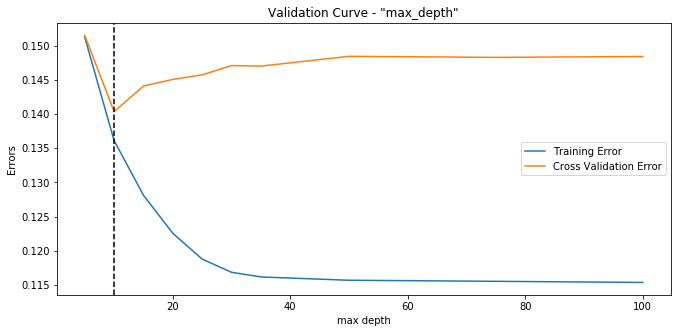

In [119]:
#Validation curve for maximum depth
clf = DecisionTreeClassifier(criterion =  'entropy',min_samples_split =  100)
param_range = [5,10,15,20,25,30,35,50,75,100]
train_scores, test_scores = validation_curve(clf, X_train, y_train, param_name="max_depth", param_range=param_range,cv=3, scoring="accuracy", n_jobs=1)
train_score_mean = np.mean(train_scores,axis=1)
test_score_mean = np.mean(test_scores,axis=1)
plt.figure(figsize= (11,5))
plt.plot(param_range,1 -train_score_mean)
plt.plot(param_range,1 -test_score_mean)
plt.axvline(x=10,color='k', linestyle='--')
plt.xlabel('max depth')
plt.ylabel('Errors')
plt.legend(['Training Error', 'Cross Validation Error'])
plt.title('Validation Curve - "max_depth"')
plt.show()

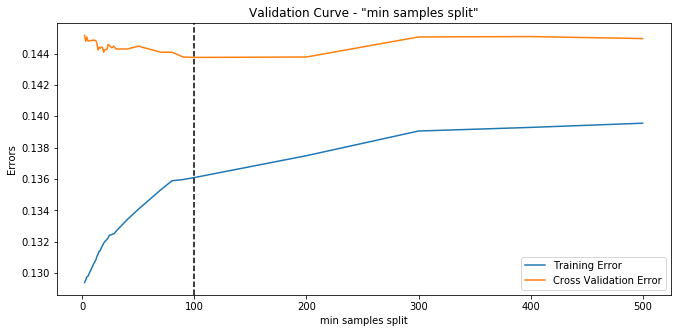

min_sample_split for minimum Cross validation error: 100


In [121]:
#Validation curve for min samples split
clf = DecisionTreeClassifier(criterion =  'entropy',max_depth =10 )
param_range = [2,3,4,5,10,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30, 40, 50, 70, 80, 90, 100, 200,300,400, 500]
train_scores, test_scores = validation_curve(clf, X_train, y_train, param_name="min_samples_split", param_range = param_range,cv=3, scoring="accuracy", n_jobs=1)
train_score_mean = np.mean(train_scores,axis=1)
test_score_mean = np.mean(test_scores,axis=1)
plt.figure(figsize= (11,5))
plt.plot(param_range,1 -train_score_mean)
plt.plot(param_range,1 -test_score_mean)
plt.axvline(x=param_range[np.argmin(1 - test_score_mean)],color='k', linestyle='--')
plt.xlabel('min samples split')
plt.ylabel('Errors')
plt.legend(['Training Error', 'Cross Validation Error'])
plt.title('Validation Curve - "min samples split"')
plt.show()
print('min_sample_split for minimum Cross validation error: {}'.format(param_range[np.argmin(1-test_score_mean)]))

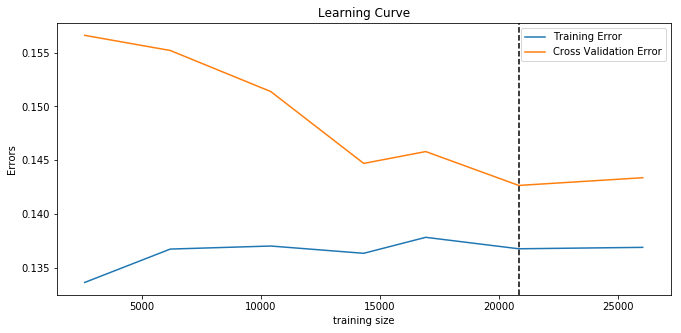

In [44]:
#Learning Curve 
clf = DecisionTreeClassifier(criterion =  'entropy', max_depth =  10, min_samples_split =  100)
train_sizes, train_scores, test_scores = learning_curve(clf,X_train,y_train,train_sizes = np.array([0.1, 0.238, 0.4, 0.55, 0.65, 0.8, 1]),cv = 3)
train_score_mean = np.mean(train_scores,axis=1)
test_score_mean = np.mean(test_scores,axis=1)
plt.figure(figsize= (11,5))
plt.plot(train_sizes,1 -train_score_mean)
plt.plot(train_sizes,1 -test_score_mean)
plt.xlabel('training size')
plt.ylabel('Errors')
plt.legend(['Training Error', 'Cross Validation Error'])
plt.axvline(x=train_sizes[np.argmin(1 - np.array(test_score_mean))],color='k', linestyle='--')
plt.title('Learning Curve')
plt.show()

In [120]:
#Decision Tree
t1 = time.time()
RandInd = np.random.choice(len(X_train),20000)
Rtrain = X_train[RandInd,:]
Rlabels = y_train[RandInd]
clf1 = DecisionTreeClassifier(criterion='entropy', max_depth=10, min_samples_split =100)
clf1.fit(Rtrain,Rlabels)
y_pred1 = clf1.predict(X_test)
t2 = time.time()
print('Running time: {}'.format(t2-t1))

Running time: 0.17387914657592773


In [121]:
t1 = time.time()

#Final accuracy score for Decision tree with pruning
print("Final accuracy score for Decision tree: {}".format(accuracy_score(y_test, y_pred1)))
t2 = time.time()
print('Running time: {}'.format(t2-t1))

Final accuracy score for Decision tree: 0.8529020370559934
Running time: 0.002685546875


# SVM

In [13]:
#Grid Search CV on random subset of data
#3 fold cross validation

clf = SVC(C = 100, kernel = 'rbf', gamma = 0.01)
RandInd = np.random.choice(len(X_train),5000)
Rtrain = X_train[RandInd,:]
Rlabels = y_train[RandInd]
parameter_grid = {
                 'C' : [0.01,0.05,1,10,100,500],
                 'gamma': [0.01,0.05,0.1,1,10,50,100],
                 'kernel': ['rbf']
                 }
grid_search = GridSearchCV(clf, param_grid=parameter_grid, cv=3)
grid_search.fit(Rtrain, Rlabels)
print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))

Best score: 0.8458
Best parameters: {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}


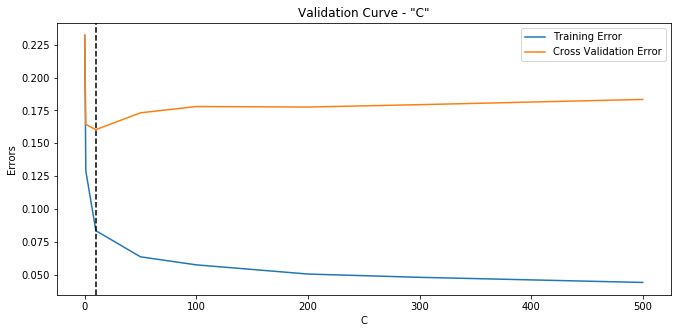

C for min cross validation error: 10


In [17]:
#Validation curve for C
clf = SVC(C = 10, gamma = 0.01, kernel = 'rbf')
param_range = [0.01,0.05,1,10,50,100,200,300,500]
RandInd = np.random.choice(len(X_train),5000)
Rtrain = X_train[RandInd,:]
Rlabels = y_train[RandInd]
train_scores, test_scores = validation_curve(clf, Rtrain, Rlabels, param_name="C", param_range=param_range,cv=3, scoring="accuracy", n_jobs=1)
train_score_mean = np.mean(train_scores,axis=1)
test_score_mean = np.mean(test_scores,axis=1)
plt.figure(figsize= (11,5))
plt.plot(param_range,1 -train_score_mean)
plt.plot(param_range,1 -test_score_mean)
plt.axvline(x=param_range[np.argmin(1 - test_score_mean)],color='k', linestyle='--')
plt.xlabel('C')
plt.ylabel('Errors')
plt.legend(['Training Error', 'Cross Validation Error'])
plt.title('Validation Curve - "C"')
plt.show()
print('C for min cross validation error: {}'.format(param_range[np.argmin(1-test_score_mean)]))

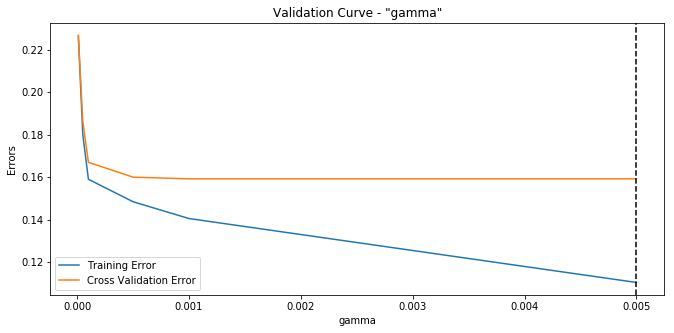

gamma for min cross validation error: 0.005


In [49]:
#Validation curve for C
clf = SVC(C = 10, gamma = 0.01, kernel = 'rbf')
param_range = [0.00001,0.00005,0.0001, 0.0005,0.001, 0.005]
RandInd = np.random.choice(len(X_train),5000)
Rtrain = X_train[RandInd,:]
Rlabels = y_train[RandInd]
train_scores, test_scores = validation_curve(clf, Rtrain, Rlabels, param_name="gamma", param_range=param_range,cv=3, scoring="accuracy", n_jobs=1)
train_score_mean = np.mean(train_scores,axis=1)
test_score_mean = np.mean(test_scores,axis=1)
plt.figure(figsize= (11,5))
plt.plot(param_range,1 -train_score_mean)
plt.plot(param_range,1 -test_score_mean)
plt.axvline(x=param_range[np.argmin(1 - test_score_mean)],color='k', linestyle='--')
plt.xlabel('gamma')
plt.ylabel('Errors')
plt.legend(['Training Error', 'Cross Validation Error'])
plt.title('Validation Curve - "gamma"')
plt.show()
print('gamma for min cross validation error: {}'.format(param_range[np.argmin(1-test_score_mean)]))

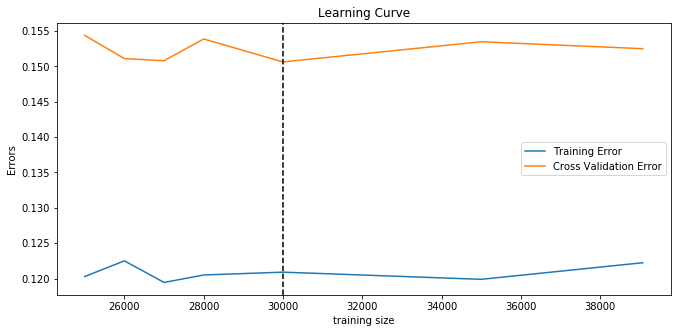

In [35]:
clf = SVC(C = 10, kernel = 'rbf', gamma = 0.005)
train_score = []
test_score = []
train_sizes = [25000, 26000, 27000, 28000, 30000, 35000, 39073]
for ts in train_sizes:
    cs = len(X_train) - ts
    RandInd = np.random.choice(len(X_train),ts)
    Rtrain = X_train[RandInd,:]
    Rlabels = y_train[RandInd]
    Rtest = X_train[list(set(list(range(0,len(X_train)))) - set(RandInd)),:]
    Rtest_lab = y_train[list(set(list(range(0,len(X_train)))) - set(RandInd))]
    clf.fit(Rtrain,Rlabels)
    y_pred_train = clf.predict(Rtrain)
    train_score.append(accuracy_score(Rlabels,y_pred_train))
    y_pred_test = clf.predict(Rtest)
    test_score.append(accuracy_score(Rtest_lab,y_pred_test))

#Plotting learning curve
#Plotting
plt.figure(figsize= (11,5))
plt.plot(train_sizes,1 - np.array(train_score))
plt.plot(train_sizes,1 - np.array(test_score))
plt.axvline(x=train_sizes[np.argmin(1 - np.array(test_score))],color='k', linestyle='--')
plt.xlabel('training size')
plt.ylabel('Errors')
plt.legend(['Training Error', 'Cross Validation Error'])
plt.title('Learning Curve')
plt.show()

In [122]:
#SVM
t1 = time.time()
RandInd = np.random.choice(len(X_train),len(X_train))
Rtrain = X_train[RandInd,:]
Rlabels = y_train[RandInd]
clf2 = SVC(C = 10, kernel = 'rbf', gamma = 0.005)
clf2.fit(Rtrain,Rlabels)
y_pred2 = clf2.predict(X_test)
t2 = time.time()
print('Running time: {}'.format(t2-t1))

Running time: 181.96169018745422


In [123]:
t1 = time.time()
print('Final accuracy score for SVM : {}'.format(accuracy_score(y_test,y_pred2)))
t2 = time.time()
print('Running time: {}'.format(t2-t1))

Final accuracy score for SVM : 0.8485003582761798
Running time: 0.0036649703979492188


In [14]:
#Boosting

In [38]:
#Grid Search CV on random subset of data
#3 fold cross validation

clf = AdaBoostClassifier(base_estimator = DecisionTreeClassifier(criterion =  'entropy', max_depth =  10, min_samples_split =  100), learning_rate = 0.8, n_estimators=20)
RandInd = np.random.choice(len(X_train),5000)
Rtrain = X_train[RandInd,:]
Rlabels = y_train[RandInd]
parameter_grid = {
                 'learning_rate' : [0.1,0.3,0.5,0.7,0.9,1],
                 'n_estimators': [1,10,20,30,40,50,70,100,200],
                 }
grid_search = GridSearchCV(clf, param_grid=parameter_grid, cv=3)
grid_search.fit(Rtrain, Rlabels)
print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))

Best score: 0.8582
Best parameters: {'learning_rate': 0.1, 'n_estimators': 10}


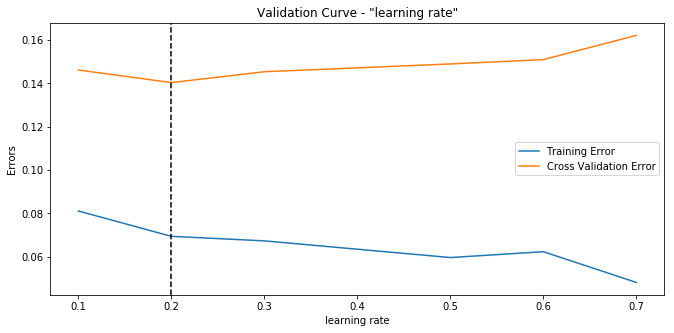

learning rate for min cross validation error: 0.2


In [52]:
#Validation curve for learning rate
clf3 = AdaBoostClassifier(base_estimator = DecisionTreeClassifier(criterion =  'entropy', max_depth =  10, min_samples_split =  100), learning_rate = 0.1, n_estimators=10)
param_range = [0.1,0.2,0.3,0.5,0.6,0.7]
RandInd = np.random.choice(len(X_train),5000)
Rtrain = X_train[RandInd,:]
Rlabels = y_train[RandInd]
train_scores, test_scores = validation_curve(clf3, Rtrain, Rlabels, param_name = "learning_rate", param_range = param_range, cv = 3, scoring = "accuracy", n_jobs=1)
train_score_mean = np.mean(train_scores, axis=1)
test_score_mean = np.mean(test_scores, axis=1)
plt.figure(figsize = (11,5))
plt.plot(param_range,1 - train_score_mean)
plt.plot(param_range,1 - test_score_mean)
plt.axvline(x = param_range[np.argmin(1 - test_score_mean)],color='k', linestyle='--')
plt.xlabel('learning rate')
plt.ylabel('Errors')
plt.legend(['Training Error', 'Cross Validation Error'])
plt.title('Validation Curve - "learning rate"')
plt.show()
print('learning rate for min cross validation error: {}'.format(param_range[np.argmin(1-test_score_mean)]))

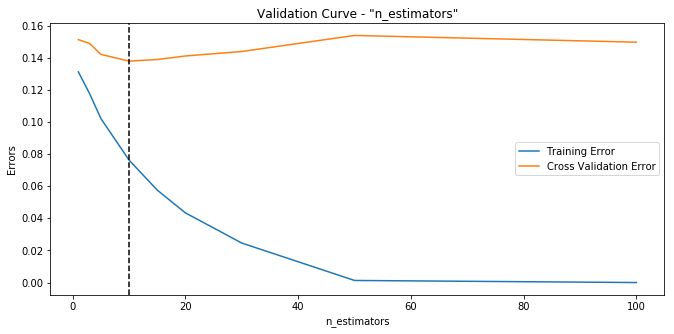

no of estimators for min cross validation error: 10


In [53]:
#Validation curve for no of estimators
clf3 = AdaBoostClassifier(base_estimator = DecisionTreeClassifier(criterion =  'entropy', max_depth =  10, min_samples_split =  100), learning_rate = 0.2, n_estimators=10)
param_range = [1, 3, 5, 10, 15, 20, 30, 50, 100]
RandInd = np.random.choice(len(X_train),5000)
Rtrain = X_train[RandInd,:]
Rlabels = y_train[RandInd]
train_scores, test_scores = validation_curve(clf3, Rtrain, Rlabels, param_name = "n_estimators", param_range = param_range, cv = 3, scoring = "accuracy", n_jobs=1)
train_score_mean = np.mean(train_scores, axis=1)
test_score_mean = np.mean(test_scores, axis=1)
plt.figure(figsize = (11,5))
plt.plot(param_range,1 - train_score_mean)
plt.plot(param_range,1 - test_score_mean)
plt.axvline(x = param_range[np.argmin(1 - test_score_mean)],color='k', linestyle='--')
plt.xlabel('n_estimators')
plt.ylabel('Errors')
plt.legend(['Training Error', 'Cross Validation Error'])
plt.title('Validation Curve - "n_estimators"')
plt.show()
print('no of estimators for min cross validation error: {}'.format(param_range[np.argmin(1-test_score_mean)]))

In [124]:
t1 = time.time()
RandInd = np.random.choice(len(X_train),39073)
Rtrain = X_train[RandInd,:]
Rlabels = y_train[RandInd]
clf3 = AdaBoostClassifier(base_estimator = DecisionTreeClassifier(criterion =  'entropy', max_depth =  10, min_samples_split =  100), learning_rate = 0.2, n_estimators=10)
clf3.fit(Rtrain,Rlabels)
y_pred3 = clf3.predict(X_test)
t2 = time.time()
print('Runing time: {}'.format(t2-t1))

Runing time: 3.6890275478363037


In [125]:
t1 = time.time()

print('Final accuracy score for Boosted Decision Tree : {}'.format(accuracy_score(y_test,y_pred3)))
t2 = time.time()
print('Runing time: {}'.format(t2-t1))

Final accuracy score for Boosted Decision Tree : 0.8616030299928344
Runing time: 0.0011417865753173828


#KNN

In [75]:
#Grid Search CV on random subset of data
#3 fold cross validation

clf4 = KNeighborsClassifier(n_neighbors = 5,weights = 'distance', algorithm = 'auto')
RandInd = np.random.choice(len(X_train),10000)
Rtrain = X_train[RandInd,:]
Rlabels = y_train[RandInd]
parameter_grid = {
                 'n_neighbors' : [100,120, 130, 150, 200, 250, 300, 350, 500],
                 'weights': ['uniform', 'distance'],
                 }
grid_search = GridSearchCV(clf4, param_grid=parameter_grid, cv=3)
grid_search.fit(Rtrain, Rlabels)
print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))

Best score: 0.8629
Best parameters: {'n_neighbors': 120, 'weights': 'distance'}


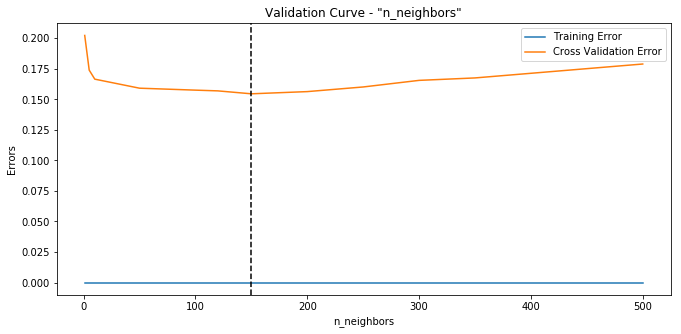

n_neighbors for min cross validation error: 150


In [78]:
#Validation curve for n_neighbors
clf4 = KNeighborsClassifier(n_neighbors = 120, weights = 'distance', algorithm = 'auto')
param_range = [1, 5, 10, 50, 100,120, 130, 150, 200, 250, 300, 350, 500]
RandInd = np.random.choice(len(X_train),5000)
Rtrain = X_train[RandInd,:]
Rlabels = y_train[RandInd]
train_scores, test_scores = validation_curve(clf4, Rtrain, Rlabels, param_name = "n_neighbors", param_range = param_range, cv = 3, scoring = "accuracy", n_jobs=1)
train_score_mean = np.mean(train_scores, axis=1)
test_score_mean = np.mean(test_scores, axis=1)
plt.figure(figsize = (11,5))
plt.plot(param_range,1 - train_score_mean)
plt.plot(param_range,1 - test_score_mean)
plt.axvline(x = param_range[np.argmin(1 - test_score_mean)],color='k', linestyle='--')
plt.xlabel('n_neighbors')
plt.ylabel('Errors')
plt.legend(['Training Error', 'Cross Validation Error'])
plt.title('Validation Curve - "n_neighbors"')
plt.show()
print('n_neighbors for min cross validation error: {}'.format(param_range[np.argmin(1-test_score_mean)]))

In [128]:
t1 = time.time()
RandInd = np.random.choice(len(X_train),len(X_train))
Rtrain = X_train[RandInd,:]
Rlabels = y_train[RandInd]
clf4 = KNeighborsClassifier(n_neighbors = 150,weights = 'distance', algorithm = 'auto')
clf4.fit(Rtrain,Rlabels)
y_pred4 = clf4.predict(X_test)
t2 = time.time()
print('Running time: {}'.format(t2-t1))

Running time: 72.16110682487488


In [129]:
t1 = time.time()
print('Final accuracy score for K nearest neighbours : {}'.format(accuracy_score(y_test,y_pred4)))
t2 = time.time()
print('Running time: {}'.format(t2-t1))

Final accuracy score for K nearest neighbours : 0.8295629030607022
Running time: 0.0018227100372314453


##Neural networks

In [138]:
#Grid Search CV on random subset of data
#3 fold cross validation

clf5 = MLPClassifier(hidden_layer_sizes=(105,1,2),max_iter=1000)
RandInd = np.random.choice(len(X_train),10000)
Rtrain = X_train[RandInd,:]
Rlabels = y_train[RandInd]
parameter_grid = {
                 'hidden_layer_sizes' : [(105,1,2),(105,2,2),(105,3,2),(105,5,2),(105,7,2),(105,8,2),(105,11,2)],
                 'max_iter': [500, 700, 900, 1000, 1200, 1400, 1600, 2000]
                 }
grid_search = GridSearchCV(clf5, param_grid=parameter_grid, cv=3)
grid_search.fit(Rtrain, Rlabels)
print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))

Best score: 0.8537
Best parameters: {'hidden_layer_sizes': (105, 8, 2), 'max_iter': 700}


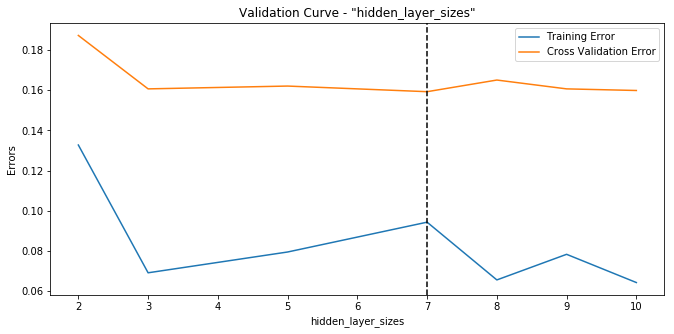

hidden_layer_size for min cross validation error: (105, 7, 2)


In [142]:
#Validation curve for hidden layer size
clf = MLPClassifier(hidden_layer_sizes=(105,1,2),max_iter=700)
param_range = [(105,2,2),(105,3,2),(105,5,2),(105,7,2),(105,8,2),(105,9,2), (105,10,2)]
RandInd = np.random.choice(len(X_train),10000)
Rtrain = X_train[RandInd,:]
Rlabels = y_train[RandInd]
train_scores, test_scores = validation_curve(clf, Rtrain, Rlabels, param_name="hidden_layer_sizes", param_range=param_range,cv=3, scoring="accuracy", n_jobs=1)
train_score_mean = np.mean(train_scores,axis=1)
test_score_mean = np.mean(test_scores,axis=1)
plt.figure(figsize= (11,5))
param_range_hidden = [2,3,5,7,8,9,10]
plt.plot(param_range_hidden,1 -train_score_mean)
plt.plot(param_range_hidden,1 -test_score_mean)
plt.axvline(x=param_range_hidden[np.argmin(1 - test_score_mean)],color='k', linestyle='--')
plt.xlabel('hidden_layer_sizes')
plt.ylabel('Errors')
plt.legend(['Training Error', 'Cross Validation Error'])
plt.title('Validation Curve - "hidden_layer_sizes"')
plt.show()
print('hidden_layer_size for min cross validation error: {}'.format(param_range[np.argmin(1-test_score_mean)]))

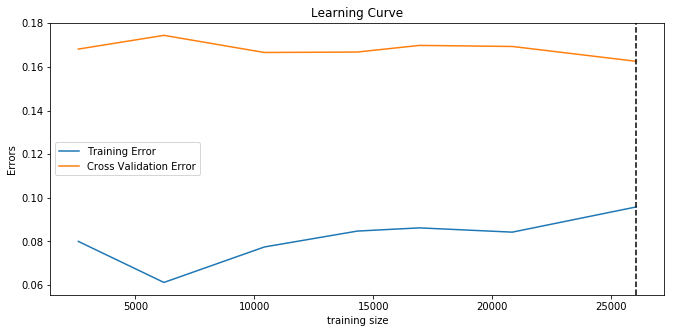

In [143]:
#Learning Curve 
clf = MLPClassifier(hidden_layer_sizes=(105,7,2),max_iter=700)
train_sizes, train_scores, test_scores = learning_curve(clf,X_train,y_train,train_sizes = np.array([0.1, 0.238, 0.4, 0.55, 0.65, 0.8, 1]),cv = 3)
train_score_mean = np.mean(train_scores,axis=1)
test_score_mean = np.mean(test_scores,axis=1)
plt.figure(figsize= (11,5))
plt.plot(train_sizes,1 -train_score_mean)
plt.plot(train_sizes,1 -test_score_mean)
plt.xlabel('training size')
plt.ylabel('Errors')
plt.legend(['Training Error', 'Cross Validation Error'])
plt.axvline(x=train_sizes[np.argmin(1 - np.array(test_score_mean))],color='k', linestyle='--')
plt.title('Learning Curve')
plt.show()

In [154]:
t1 = time.time()
RandInd = np.random.choice(len(X_train),len(X_train))
Rtrain = X_train[RandInd,:]
Rlabels = y_train[RandInd]
clf5 = MLPClassifier(hidden_layer_sizes=(105,7,2),max_iter=700)
clf5.fit(Rtrain,Rlabels)
y_pred5 = clf5.predict(X_test)
t2 = time.time()
print('Running time: {}'.format(t2-t1))

Running time: 11.973669052124023


In [155]:
t1 = time.time()
print('Final accuracy score for Multi layer perceptron classifier : {}'.format(accuracy_score(y_test,y_pred5)))
t2 = time.time()
print('Running time: {}'.format(t2-t1))

Final accuracy score for Multi layer perceptron classifier : 0.8292558091923431
Running time: 0.0010483264923095703


In [103]:
y_pred5

array([0, 0, 1, ..., 0, 0, 1])